# Notebook to define ensemble for production, cm level
Version developed for ViEWS monthly updates: Fatalities003
## Including ensemble weighting

This notebook defines the ensemble used for production: selects a set of pre-trained models, retrieves and calibrates them, computes weights, and computes and stores the ensemble model predictions.

Models are stored in model storage and most of them specified in the notebook fat_cm_constituentmodels

The notebook draws on the following files in this repository:

Script file: 
    Ensembling.py
    FetchData.py

Lists of models:
    ModelList_cm_{dev_id}.csv (not yet functional)
    List of pickles at local directory (will rewrite to drop dependence on this)

# Note
### Numbers in the models 11, 12, 13 are log values even if the column for model 12, 13 is ged_sb_dep
### Not sure whether the calibrated ensemble model should go through the calibration function or ensembling the calibrated models.
### There are negative values after calibration


In [132]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook

# Views 3
from viewser.operations import fetch
from viewser import Queryset, Column
import views_runs
from views_partitioning import data_partitioner, legacy
from stepshift import views
# import views_dataviz
from views_runs import storage, ModelMetadata
from views_runs.storage import store, retrieve, fetch_metadata
from views_forecasts.extensions import *

#sklearn
from sklearn.metrics import mean_squared_error

# Other packages
import pickle as pkl
import getpass
import copy
from pathlib import Path
# pd.set_option('display.float_format', lambda x: '%.6f' % x)

# Packages from this repository, Tools folder
import sys
sys.path.append('../')
sys.path.append('../Tools')
sys.path.append('../Intermediates')
import os

from Ensembling import CalibratePredictions, RetrieveStoredPredictions, mean_sd_calibrated, gam_calibrated
from FetchData import FetchData, RetrieveFromList
from ViewsEstimators import *

In [36]:
# Common parameters:

dev_id = 'Fatalities003'
run_id = 'Fatalities003'
EndOfHistory = 509
RunGeneticAlgo = True
level = 'cm'
get_future = False

username = getpass.getuser()

steps = [*range(1, 36+1, 1)] # Which steps to train and predict for

fi_steps = [1,3,6,12,36]
# Specifying partitions

calib_partitioner_dict = {"train":(121,396),"predict":(397,444)}
test_partitioner_dict = {"train":(121,444),"predict":(445,492)}
future_partitioner_dict = {"train":(121,492),"predict":(493,504)}
calib_partitioner =  views_runs.DataPartitioner({"calib":calib_partitioner_dict})
test_partitioner =  views_runs.DataPartitioner({"test":test_partitioner_dict})
future_partitioner =  views_runs.DataPartitioner({"future":future_partitioner_dict})

Mydropbox = f'/Users/{username}/Dropbox (ViEWS)/ViEWS/'
localpath = f'/Users/{username}/Pickles/'
overleafpath = f'/Users/{username}/Dropbox (ViEWS)/Apps/Overleaf/VIEWS documentation {dev_id}/'


In [37]:
from ModelDefinitions import DefineEnsembleModels

ModelList = DefineEnsembleModels(level)
    
i = 0
for model in ModelList:
    print(i, model['modelname'], model['data_train'])
    i = i + 1

0 fatalities003_nl_baseline_rf baseline003
1 fatalities003_nl_conflicthistory_rf conflict_ln
2 fatalities003_nl_conflicthistory_hurdle_lgb conflict_ln
3 fatalities003_nl_conflicthistory_long_xgb conflictlong_ln
4 fatalities003_nl_vdem_hurdle_xgb vdem_short
5 fatalities003_nl_wdi_rf wdi_short
6 fatalities003_nl_topics_rf topics_003
7 fatalities003_nl_topics_xgb topics_003
8 fatalities003_nl_topics_hurdle_lgb topics_003
9 fatalities003_nl_joint_broad_rf joint_broad
10 fatalities003_nl_joint_broad_hurdle_rf joint_broad
11 fatalities003_joint_narrow_xgb joint_narrow
12 fatalities003_nl_joint_narrow_hurdle_xgb joint_narrow
13 fatalities003_nl_joint_narrow_hurdle_lgb joint_narrow
14 fatalities003_nl_all_pca3_xgb all_features


# Retrieve and calibrate predictions

In [38]:
# Retrieving the predictions for calibration and test partitions
# The ModelList contains the predictions organized by model

ModelList = RetrieveStoredPredictions(ModelList, steps, EndOfHistory, dev_id, level, get_future)

0 fatalities003_nl_baseline_rf
pr_56_cm_fatalities003_nl_baseline_rf_calib.parquet
pr_56_cm_fatalities003_nl_baseline_rf_test.parquet
1 fatalities003_nl_conflicthistory_rf
pr_56_cm_fatalities003_nl_conflicthistory_rf_calib.parquet
pr_56_cm_fatalities003_nl_conflicthistory_rf_test.parquet
2 fatalities003_nl_conflicthistory_hurdle_lgb
pr_56_cm_fatalities003_nl_conflicthistory_hurdle_lgb_calib.parquet
pr_56_cm_fatalities003_nl_conflicthistory_hurdle_lgb_test.parquet
3 fatalities003_nl_conflicthistory_long_xgb
pr_56_cm_fatalities003_nl_conflicthistory_long_xgb_calib.parquet
pr_56_cm_fatalities003_nl_conflicthistory_long_xgb_test.parquet
4 fatalities003_nl_vdem_hurdle_xgb
pr_56_cm_fatalities003_nl_vdem_hurdle_xgb_calib.parquet
pr_56_cm_fatalities003_nl_vdem_hurdle_xgb_test.parquet
5 fatalities003_nl_wdi_rf
pr_56_cm_fatalities003_nl_wdi_rf_calib.parquet
pr_56_cm_fatalities003_nl_wdi_rf_test.parquet
6 fatalities003_nl_topics_rf
pr_56_cm_fatalities003_nl_topics_rf_calib.parquet
pr_56_cm_fatali

In [39]:
ModelList[11]['predictions_calib_df'] = ModelList[11]['predictions_calib_df'].applymap(lambda x: np.exp(x) - 1)
ModelList[11]['predictions_calib_df'].rename(columns={'ln_ged_sb_dep':'ged_sb_dep'}, inplace=True)
ModelList[11]['predictions_test_df'] = ModelList[11]['predictions_test_df'].applymap(lambda x: np.exp(x) - 1)
ModelList[11]['predictions_test_df'].rename(columns={'ln_ged_sb_dep':'ged_sb_dep'}, inplace=True)

ModelList[12]['predictions_calib_df'] = ModelList[12]['predictions_calib_df'].applymap(lambda x: np.exp(x) - 1)
ModelList[12]['predictions_test_df'] = ModelList[12]['predictions_test_df'].applymap(lambda x: np.exp(x) - 1)

ModelList[13]['predictions_calib_df'] = ModelList[13]['predictions_calib_df'].applymap(lambda x: np.exp(x) - 1)
ModelList[13]['predictions_test_df'] = ModelList[13]['predictions_test_df'].applymap(lambda x: np.exp(x) - 1)


# Create ensemble model using equal weights

In [40]:
dfs_calib = [model['predictions_calib_df'] for model in ModelList]
dfs_test = [model['predictions_test_df'] for model in ModelList]
weight = 1/15
ensemble_df_calib = pd.concat(dfs_calib, axis=1)
ensemble_df_test = pd.concat(dfs_test, axis=1)

In [41]:
ensemble_df_calib['ensemble_ged_sb_dep'] = weight * sum([df.iloc[:, 0] for df in dfs_calib])
ensemble_df_test['ensemble_ged_sb_dep'] = weight * sum([df.iloc[:, 0] for df in dfs_test])

for i in range(1, 37):
    ensemble_df_calib[f'ensemble_step_pred_{i}'] = weight * sum([df.iloc[:, i] for df in dfs_calib])
ensemble_df_calib.drop(ensemble_df_calib.columns[:37], axis=1, inplace=True)
cols = ModelList[0]['predictions_calib_df'].columns
ensemble_df_calib.columns = cols

for i in range(1, 37):
    ensemble_df_test[f'ensemble_step_pred_{i}'] = weight * sum([df.iloc[:, i] for df in dfs_test])
ensemble_df_test.drop(ensemble_df_test.columns[:37], axis=1, inplace=True)
cols = ModelList[0]['predictions_test_df'].columns
ensemble_df_test.columns = cols


In [42]:
ModelList.append({'modelname': 'ensemble', 'predictions_calib_df': ensemble_df_calib, 'predictions_test_df': ensemble_df_test})
ModelList = CalibratePredictions(ModelList, steps, EndOfHistory)

Calibrating models
fatalities003_nl_baseline_rf
fatalities003_nl_conflicthistory_rf
fatalities003_nl_conflicthistory_hurdle_lgb
fatalities003_nl_conflicthistory_long_xgb
fatalities003_nl_vdem_hurdle_xgb
fatalities003_nl_wdi_rf
fatalities003_nl_topics_rf
fatalities003_nl_topics_xgb
fatalities003_nl_topics_hurdle_lgb
fatalities003_nl_joint_broad_rf
fatalities003_nl_joint_broad_hurdle_rf
fatalities003_joint_narrow_xgb
fatalities003_nl_joint_narrow_hurdle_xgb
fatalities003_nl_joint_narrow_hurdle_lgb
fatalities003_nl_all_pca3_xgb
ensemble


# Correlation matrix

In [43]:
model_calib_cor_matrix = []
model_test_cor_matrix = []
for model in ModelList:
    model_calib_cor_matrix.append((model['predictions_calib_df'].iloc[:, 1:-1]).corr())
    model_test_cor_matrix.append((model['predictions_test_df'].iloc[:, 1:-1]).corr())


# Evaluation 

In [44]:
def calculate_step_rmse(ModelList, prediction_df):
    pred_cols = [f'step_pred_{str(i)}' for i in steps] 
    step_rmse = {col:[] for col in pred_cols}
    for model in ModelList:      
        df = model[prediction_df]
        for col in pred_cols:
            mse = mean_squared_error(df['ged_sb_dep'], df[col])
            step_rmse[col].append(np.sqrt(mse))
    return pd.DataFrame(step_rmse)
    
def calculate_row_mse(ModelList, prediction_df):
    for model in ModelList:
        df = model[prediction_df]
        pred_cols = [f'step_pred_{str(i)}' for i in steps]
        df['mse'] = df.apply(lambda row: mean_squared_error([row['ged_sb_dep']] * 36, 
                            [row[col] for col in pred_cols]), axis=1)

def get_model_rmse(ModelList, prediction_df):
    model_rmse = {'model': [], 'rmse': []}
    for model in ModelList:
        name = model['modelname']
        df = model[prediction_df]
        model_rmse['model'].append(name)
        model_rmse['rmse'].append(np.sqrt(df['mse'].mean()))
    df_model_rmse = pd.DataFrame(model_rmse)
    return df_model_rmse

def get_top_10_cases(ModelList, prediction_df):
    top_10_cases = {'model': [], 'month_id': [], 'country_id': [], 'rmse': []}
    for model in ModelList:
        name = model['modelname']
        df = model[prediction_df]
        df_sorted_model = df.sort_values(by=['mse'], ascending=False).head(10)
        for _ in range(10):
            top_10_cases['model'].append(name)
        for month in df_sorted_model.index.get_level_values(level=0):
            top_10_cases['month_id'].append(month)
        for country in df_sorted_model.index.get_level_values(level=1):
            top_10_cases['country_id'].append(country)  
        for mse in df_sorted_model['mse']:
            top_10_cases['rmse'].append(np.sqrt(mse))
    pd_top_10_cases = pd.DataFrame(top_10_cases)
    pd_top_10_cases.set_index('model', inplace=True)
    return pd_top_10_cases


In [45]:
ModelList_eval = copy.deepcopy(ModelList)
df_calib_step_rmse = calculate_step_rmse(ModelList_eval, 'predictions_calib_df')
df_test_step_rmse = calculate_step_rmse(ModelList_eval, 'predictions_test_df')

calculate_row_mse(ModelList_eval, 'predictions_calib_df')
calculate_row_mse(ModelList_eval, 'predictions_test_df')
calculate_row_mse(ModelList_eval, 'calib_df_cal_expand')
calculate_row_mse(ModelList_eval, 'calib_df_cal_gam')
calculate_row_mse(ModelList_eval, 'test_df_cal_expand')
calculate_row_mse(ModelList_eval, 'test_df_cal_gam')

# Calculate the rmse of each model
df_calib_rmse = get_model_rmse(ModelList_eval, 'predictions_calib_df')
df_calib_expand_rmse = get_model_rmse(ModelList_eval, 'calib_df_cal_expand')
df_calib_gam_rmse = get_model_rmse(ModelList_eval, 'calib_df_cal_gam')

df_test_rmse = get_model_rmse(ModelList_eval, 'predictions_test_df') 
df_test_expand_rmse = get_model_rmse(ModelList_eval, 'test_df_cal_expand')
df_test_gam_rmse = get_model_rmse(ModelList_eval, 'test_df_cal_gam')

# Get the sorted rmse of each model
# df_calib_rmse_sorted = get_model_rmse(ModelList_eval, 'predictions_calib_df').sort_values(by=['rmse'])
# df_calib_expand_rmse_sorted = get_model_rmse(ModelList_eval, 'calib_df_cal_expand').sort_values(by=['rmse'])
# df_calib_gam_rmse_sorted = get_model_rmse(ModelList_eval, 'calib_df_cal_gam').sort_values(by=['rmse'])
 
# df_test_rmse_sorted = get_model_rmse(ModelList_eval, 'predictions_test_df') 
# df_test_expand_rmse_sorted = get_model_rmse(ModelList_eval, 'test_df_cal_expand').sort_values(by=['rmse'])
# df_test_gam_rmse_sorted = get_model_rmse(ModelList_eval, 'test_df_cal_gam').sort_values(by=['rmse'])

# Get the top 10 cases for each model
df_calib_top10 = get_top_10_cases(ModelList_eval, 'predictions_calib_df')
df_calib_expand_top10 = get_top_10_cases(ModelList_eval, 'calib_df_cal_expand')
df_calib_gam_top10 = get_top_10_cases(ModelList_eval, 'calib_df_cal_gam')

df_test_top10 = get_top_10_cases(ModelList_eval, 'predictions_test_df')
df_test_top10 = get_top_10_cases(ModelList_eval, 'test_df_cal_expand')
df_test_top10 = get_top_10_cases(ModelList_eval, 'test_df_cal_gam')


In [63]:
for i,model in enumerate(ModelList):
    print(i, model['modelname'])

0 fatalities003_nl_baseline_rf
1 fatalities003_nl_conflicthistory_rf
2 fatalities003_nl_conflicthistory_hurdle_lgb
3 fatalities003_nl_conflicthistory_long_xgb
4 fatalities003_nl_vdem_hurdle_xgb
5 fatalities003_nl_wdi_rf
6 fatalities003_nl_topics_rf
7 fatalities003_nl_topics_xgb
8 fatalities003_nl_topics_hurdle_lgb
9 fatalities003_nl_joint_broad_rf
10 fatalities003_nl_joint_broad_hurdle_rf
11 fatalities003_joint_narrow_xgb
12 fatalities003_nl_joint_narrow_hurdle_xgb
13 fatalities003_nl_joint_narrow_hurdle_lgb
14 fatalities003_nl_all_pca3_xgb
15 ensemble


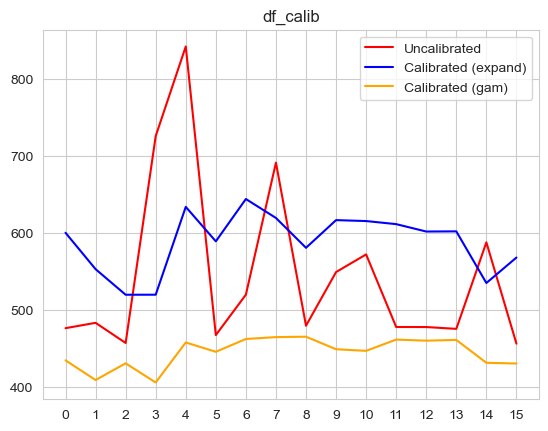

In [135]:
fig, ax = plt.subplots()
ax.plot(df_calib_rmse.index, df_calib_rmse['rmse'], color='red', label='Uncalibrated')
ax.plot(df_calib_expand_rmse.index, df_calib_expand_rmse['rmse'], color='blue', label='Calibrated (expand)')
ax.plot(df_calib_gam_rmse.index, df_calib_gam_rmse['rmse'], color='orange', label='Calibrated (gam)')

ax.legend()
ax.set_xticks(range(0, 16))
plt.title('df_calib')
plt.show()


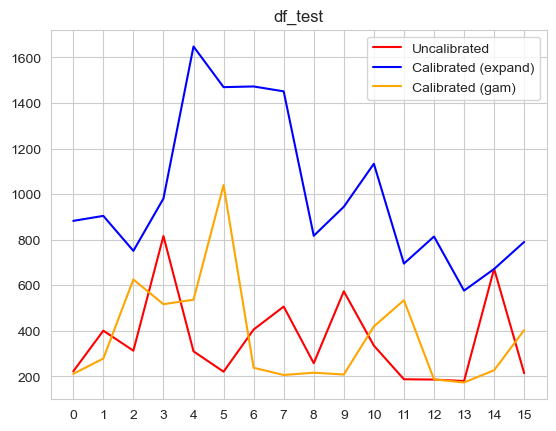

In [136]:
fig, ax = plt.subplots()
ax.plot(df_test_rmse.index, df_test_rmse['rmse'], color='red',label='Uncalibrated')
ax.plot(df_test_expand_rmse.index, df_test_expand_rmse['rmse'], color='blue', label='Calibrated (expand)')
ax.plot(df_test_gam_rmse.index, df_test_gam_rmse['rmse'], color='orange', label='Calibrated (gam)')
ax.legend()
ax.set_xticks(range(0, 16))
plt.title('df_test')
plt.show()

# Plot model prediction for each step and each month

In [170]:
def plot_prediction_each_step(model, label):
    if 'calib' in label.split('_'):
        df_category = 'calib'
    elif 'test' in label.split('_'):
        df_category = 'test'
    else: 
        raise ValueError('Wrong label.')
        
    if label.split('_')[-1] == 'expand':
        calibrate = 'Expand'
    elif label.split('_')[-1] == 'gam':
        calibrate = 'GAM'
    else:
        calibrate = 'Uncalibrated'
    df_step_sum = model[label].iloc[:, 1:].sum().reset_index()
    df_step_sum.columns = ['step', 'sum']
    name = model['modelname']
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(df_step_sum['step'], df_step_sum['sum'])
    plt.xticks(df_step_sum['step'], np.arange(1, 37))
    plt.xlabel('Step_prediction')
    plt.ylabel('Sum of fatalities for each step')
    plt.title(f'Sum of fatalities for each step ({name}, {calibrate})')
    
    savepath = Path(f'../Plots/step/{df_category}/{calibrate}')
    savepath.mkdir(parents=True, exist_ok=True)
    plt.savefig(savepath/f'{name}.jpg')
    plt.close()

def plot_prediction_each_month(model, label):
    if 'calib' in label.split('_'):
        df_category = 'calib'
    elif 'test' in label.split('_'):
        df_category = 'test'
    else: 
        raise ValueError('Wrong label.')
        
    if label.split('_')[-1] == 'expand':
        calibrate = 'Expand'
    elif label.split('_')[-1] == 'gam':
        calibrate = 'GAM'
    else:
        calibrate = 'Uncalibrated'
    df_month_step_sum = model[label].iloc[:, 1:].groupby('month_id').sum()
    df_month_sum = df_month_step_sum.sum(axis=1).reset_index()
    df_month_sum.columns = ['month_id', 'sum']
    name = model['modelname']
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(df_month_sum['month_id'], df_month_sum['sum'])
    plt.xticks(df_month_sum['month_id'], rotation=45)
    plt.xlabel('Month')
    plt.ylabel('Sum of fatalities for each month')
    plt.title(f'Sum of fatalities for each month ({name}, {calibrate})')
    
    savepath = Path(f'../Plots/month/{df_category}/{calibrate}')
    savepath.mkdir(parents=True, exist_ok=True)
    plt.savefig(savepath/f'{name}.jpg')
    plt.close()


In [171]:
for model in ModelList:
    for label in ['predictions_calib_df', 'calib_df_cal_expand', 'calib_df_cal_gam', 'predictions_test_df', 'test_df_cal_expand', 'test_df_cal_gam']:
        plot_prediction_each_step(model, label)
        plot_prediction_each_month(model, label)